In [2]:
import torch
import torch .nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

### Chuẩn bị dữ liệu

In [5]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)
df.head()


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


- Trong bài tập lần này, vì mô hình chỉ dự đoán nhiệt độ (Temperature (C)) nên ta sẽ loại
bỏ đi các cột không cần thiết trong DataFrame trước khi đưa vào tiền xử lý:

In [12]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

univariate_df.head()

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
Name: Temperature (C), dtype: float64

- Xây dựng hàm tạo cặp X, y: Cũng như bất kì các bài toán thuộc nhánh học có giám
sát trên dữ liệu dạng bảng khác, ta cần xác định X, y của bài toán sao cho phù hợp.
Thông thường, X sẽ là các đặc trưng và y sẽ là nhãn tương ứng cho các đặc trưng X
(thường được định nghĩa rõ ràng trong bảng dữ liệu). Tuy nhiên ở bài toán này, ta không
có các nhãn cụ thể theo như đề bài đưa ra. Chính vì vậy, cần phải thực hiện chỉnh sửa
Input/Output của dữ liệu sao cho phù hợp để ta có thể đưa vào mô hình.
Với việc đề bài yêu cầu sử dụng thông tin nhiệt độ của 6 giờ trước để dự đoán nhiệt độ
của 1 giờ tiếp theo, ta có thể xác định được rằng X sẽ là nhiệt độ của 6 giờ, y là nhiệt
độ của giờ tiếp theo,


- Từ đây, có thể thấy khi ta duyệt qua từng hàng trên bảng dữ liệu, ta có thể tạo ra các
cặp X, y theo đúng ý của đề bài yêu cầu, nhờ đó có thể sử dụng để đưa vào huấn luyện
mô hình. Kỹ thuật này được gọi là Windowing (coi các cặp X, y như các "cửa sổ"). Ta
sẽ thực hiện triển khai hàm windowing này như sau:

In [15]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []
    
    window_size = input_size + offset
    
    if df_end_idx is None:
        df_end_idx = len(df) - window_size
    
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size
        
        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]
        
        features.append(feature)
        labels.append(label)
    
    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)
    
    return features, labels


### CHia bộ dữ liệu train, val, test


In [13]:
print(len(univariate_df))

96453


In [16]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)


### Xây dựng Pytorch dataset

In [17]:
class WeatherForecast(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            X = self.transform(X)
        
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return X, y


### Khai báo dataloader


In [18]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)


### Xây dựng mô hình

In [19]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(
            embedding_dim, hidden_size, n_layers, batch_first=True
        )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)


In [20]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)


/media/tan/F/AIO2024_hw/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}")

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = sum(losses) / len(losses)
    acc = correct / total
    
    return loss, acc


In [22]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)


EPOCH 1:	Train loss: 126.7142	Val loss: 41.0007
EPOCH 2:	Train loss: 29.9090	Val loss: 7.3284
EPOCH 3:	Train loss: 16.1272	Val loss: 3.4280
EPOCH 4:	Train loss: 13.1546	Val loss: 3.0714
EPOCH 5:	Train loss: 11.6121	Val loss: 2.1859
EPOCH 6:	Train loss: 10.6030	Val loss: 1.8862
EPOCH 7:	Train loss: 10.1788	Val loss: 1.7658
EPOCH 8:	Train loss: 9.6496	Val loss: 1.8411
EPOCH 9:	Train loss: 9.3395	Val loss: 2.0071
EPOCH 10:	Train loss: 9.1364	Val loss: 1.6806
EPOCH 11:	Train loss: 8.8933	Val loss: 1.5724
EPOCH 12:	Train loss: 8.8007	Val loss: 1.5614
EPOCH 13:	Train loss: 8.4926	Val loss: 2.1140
EPOCH 14:	Train loss: 8.4098	Val loss: 1.8371
EPOCH 15:	Train loss: 8.2467	Val loss: 1.6703
EPOCH 16:	Train loss: 7.8909	Val loss: 1.9196
EPOCH 17:	Train loss: 7.8164	Val loss: 1.5569
EPOCH 18:	Train loss: 7.7345	Val loss: 1.9944
EPOCH 19:	Train loss: 7.5005	Val loss: 1.5792
EPOCH 20:	Train loss: 7.4500	Val loss: 1.5611
EPOCH 21:	Train loss: 7.2653	Val loss: 1.9266
EPOCH 22:	Train loss: 7.0327	Val l

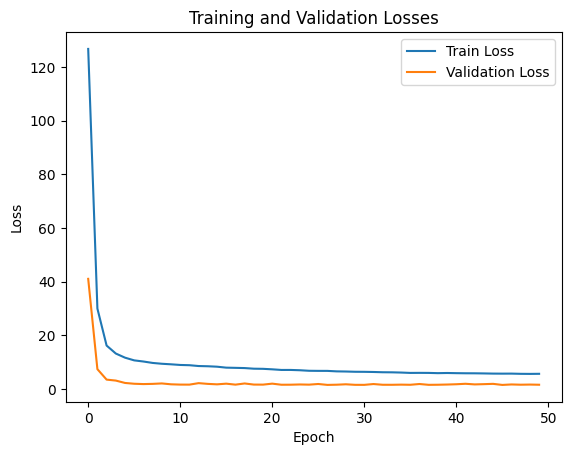

In [23]:
import matplotlib.pyplot as plt

# Plotting train_losses and val_losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [24]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val / test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val / test dataset
Val accuracy: 0.005391394504924832
Test accuracy: 0.006639692914202718


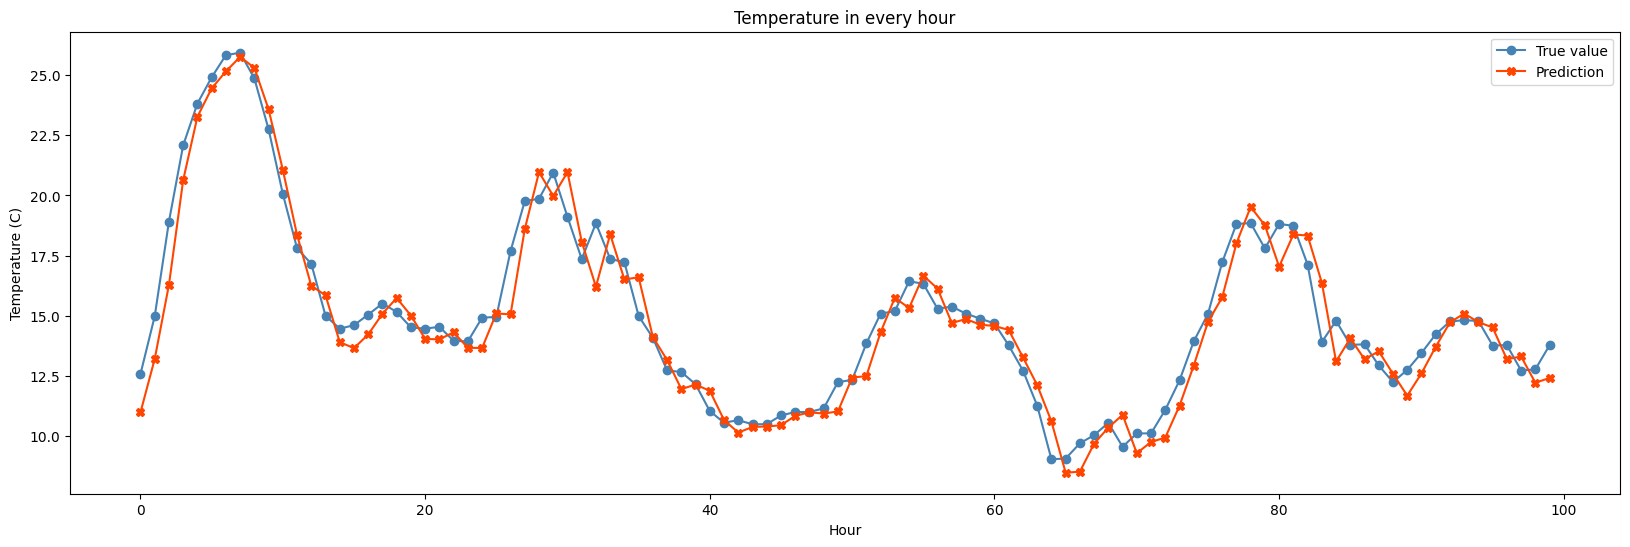

In [25]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()
    
    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')
    
    plt.title('Temperature in every hour')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)


In [26]:
import torch
import torch.nn as nn

input_tensor = torch.randn(5, 10, 10)

lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)
bilstm = nn.LSTM(
    input_size=10,
    hidden_size=20,
    num_layers=2,
    batch_first=True,
    bidirectional=True
)

output_lstm, (hidden_state_lstm, cell_state_lstm) = lstm(input_tensor)
output_bilstm, (hidden_state_bilstm, cell_state_bilstm) = bilstm(input_tensor)

print(output_lstm.shape)
print(output_bilstm.shape)


torch.Size([5, 10, 20])
torch.Size([5, 10, 40])
